## Fetch Data

This part is based on code written here: http://www.quantatrisk.com/2017/03/20/download-crypto-currency-time-series-portfolio-python/
While using an existing .csv file is nice, this code can be reused for future projects (e.g. robo advisory :D)

In [366]:
# Imports and Defaults
%matplotlib inline
import json
from bs4 import BeautifulSoup
import requests 
import pprint
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import requests
pp = pprint.PrettyPrinter(indent=4)


In [23]:
# Fetch Coinlist
def getCoinlist():

    url = "https://www.cryptocompare.com/api/data/coinlist/"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    data = json.loads(soup.prettify())
    data = data['Data']
    
    return list(sorted(data.keys()))

In [24]:
lCoins = getCoinlist()
print lCoins[0]
#pp.pprint(data[lCoins[0]])

007


In [388]:
#Borrowed Python 3.3 Code to convert datetime to timestamp
def _timestamp(time_date):

    "Return POSIX timestamp as float"
    if time_date.tzinfo is None:

        return time.mktime((time_date.year, time_date.month, time_date.day,

                             time_date.hour, time_date.minute, time_date.second,

                             -1, -1, -1)) + time_date.microsecond / 1e6
    else:

        return (time_date - datetime.utcoffset).total_seconds()

# Code from quantarisk 
# adjusted to Python 2.7
def timestamp2date(timestamp):
    # function converts a Unix timestamp into Gregorian date
    return datetime.fromtimestamp(timestamp).strftime('%Y%m%d%H%m')
 
#def date2timestamp(date):
    # function coverts Gregorian date in a given format to timestamp
#    return datetime.strptime(date, '%Y-%m-%d').timestamp()

def fetchCryptoOHLC(fsym, tsym, interval="day",timestamp_recent = None,timestamp_past = None):
    # function fetches a crypto price-series for fsym/tsym and stores
    # it in pandas DataFrame
 
    cols = ['date', 'timestamp', 'open', 'high', 'low', 'close','volumefrom','volumeto']
    lst = ['time', 'open', 'high', 'low', 'close','volumefrom','volumeto']
     
    if timestamp_recent is None:
        timestamp_today = _timestamp(datetime.today())
        curr_timestamp = timestamp_today
        #print curr_timestamp,type(curr_timestamp)
    else:
        curr_timestamp = timestamp_recent
    
    if timestamp_past is None:
        datapoints = 2000
    else:
        datapoints = calcDPs(timestamp_recent, timestamp_past, interval)
        print datapoints
        
    #limit per request
    limit = 2000
    df = pd.DataFrame(columns=cols)
    while(datapoints > 0):
        
        if datapoints < limit:
            limit = datapoints
            
        datapoints = max(0,datapoints-limit)
        #print type(tsym),type(str(int(curr_timestamp))),type(fsym)
        url = "https://min-api.cryptocompare.com/data/histo"+interval+"?fsym=" + fsym + "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + "&limit="+str(limit)
        #print url
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
        #print dic["Data"]
        for i in range(0, limit+1):
            tmp = []
            for e in enumerate(lst):
               # print e, e[0]
                x = e[0]
                y = dic['Data'][i][e[1]]
                if(x == 0):
                    tmp.append(str(timestamp2date(y)))
                tmp.append(y)
            if(np.sum(tmp[-4::]) > 0):
                df.loc[len(df)] = np.array(tmp)
            
        
        curr_timestamp = int(df.ix[0][0])
        #print curr_timestamp
#        if(j == 0):
#            df0 = df.copy()
#        else:
#            data = pd.concat([df, df0], axis=0)
    
    df.index = pd.to_datetime(df.date)
    df.drop('date', axis=1, inplace=True)
    return df

def calcDPs(timestamp_recent, timestamp_past,interval='days'):
    date_recent = datetime.fromtimestamp(timestamp_recent)
    date_past = datetime.fromtimestamp(timestamp_past)
    
    
    
    diff = date_recent - date_past
    diff_in_sec = diff.total_seconds()
#    print date_recent, date_past
#    print diff,diff.total_seconds()
    
    if interval=='hour':
        dps = np.ceil(diff_in_sec/(60.*60))
    elif interval=='minute':
        dps = np.ceil(diff_in_sec/60.)
    
    #Fallback auf Days
    else:
#        print "days",diff_in_sec
#        print diff_in_sec/(24.*60*60)
        dps = np.ceil(diff_in_sec/(24.*60*60))
      
    return int(dps)

In [339]:
24*60

1440

In [389]:
test = fetchCryptoOHLC("ETH","USD",interval="hour")

In [390]:
test2 = fetchCryptoOHLC("ETH","USD",interval="day",timestamp_recent=timestamp(datetime.now()),timestamp_past=timestamp(datetime(1988,3, 13)))

10705


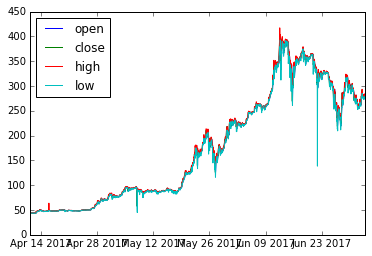

In [387]:
plt.plot(test.open)
plt.plot(test.close)
plt.plot(test.high)
plt.plot(test.low)
plt.legend(loc=2)

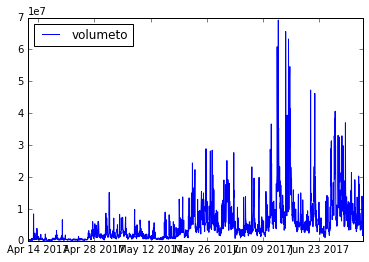

In [392]:
#plt.plot(test.volumefrom)
plt.plot(test.volumeto)
plt.legend(loc=2)